In [2]:
!pip install optuna
!pip install shap
!pip install transformers
!pip install pytorch_tabnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:
!pip install catboost dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 16.8 MB/s eta 0:00:00


In [12]:
# %% Cell 1: Import Libraries
import numpy as np
import pandas as pd
import datetime
import os
import joblib

# Machine Learning models and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import QuantileTransformer

# Advanced ML libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from pytorch_tabnet.tab_model import TabNetRegressor

# Deep Learning (Transformer-based model)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

# Hyperparameter optimization and explainability
import optuna
import shap

# For progress display
from tqdm import tqdm

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [13]:
# %% Cell 2: Data Collection – Load Predefined Dataset
DATA_PATH = "latest_mobile_data.csv"

if os.path.exists(DATA_PATH):
    df_mobiles = pd.read_csv(DATA_PATH)
    print(f"Loaded dataset from {DATA_PATH}.")
else:
    print(f"Dataset '{DATA_PATH}' not found. Generating synthetic dataset for demonstration.")
    current_year = datetime.datetime.now().year
    df_mobiles = pd.DataFrame({
        "brand": np.random.choice(["Samsung", "Apple", "Xiaomi", "Google", "OnePlus", "Huawei"], 1000),
        "model": np.random.choice(["Model A", "Model B", "Model C", "Model D"], 1000),
        "release_year": np.random.randint(2000, current_year+1, 1000),
        "ram": np.random.choice([2, 4, 6, 8, 12, 16], 1000),
        "storage": np.random.choice([32, 64, 128, 256, 512], 1000),
        "camera": np.random.uniform(8, 108, 1000),
        "screen_size": np.random.uniform(4.5, 7.0, 1000)
    })
    # Generate a synthetic price using a heuristic formula
    def simulate_price(row):
        age_factor = (current_year - row["release_year"])
        base_price = 50
        price = base_price + age_factor * 15 + row["ram"] * 20 + row["storage"] * 0.3 + row["camera"] * 8 + row["screen_size"] * 30
        price += np.random.normal(0, 50)
        return max(price, 50)
    df_mobiles["price"] = df_mobiles.apply(simulate_price, axis=1)

print("Collected mobile data sample:")
print(df_mobiles.head())


Dataset 'latest_mobile_data.csv' not found. Generating synthetic dataset for demonstration.
Collected mobile data sample:
     brand    model  release_year  ram  storage     camera  screen_size  \
0   Google  Model B          2017    2      512  80.192923     4.666735   
1  OnePlus  Model A          2003    4      256  46.480362     4.620231   
2   Xiaomi  Model B          2001    8      512  56.937645     5.239163   
3  OnePlus  Model B          2013   12      512  50.960859     6.831361   
4  OnePlus  Model C          2012    2       32  82.062615     5.808033   

         price  
0  1177.354916  
1   969.020666  
2  1280.644509  
3  1234.593202  
4  1084.969787  


In [14]:
# %% Cell 3: Data Preprocessing and Feature Engineering

def preprocess_mobile_data(df):
    current_year = datetime.datetime.now().year
    # Create additional feature: device age
    df['age'] = current_year - df['release_year']

    # One-hot encode the categorical feature "brand"
    df_encoded = pd.get_dummies(df, columns=['brand'], drop_first=True)

    # Define features and target variable (exclude phone_name, model, and release_year)
    # Note: If you wish to include model information, you can also one-hot encode it.
    X = df_encoded.drop(['price', 'release_year', 'model'], axis=1)
    y = df_encoded['price']

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Normalize features with QuantileTransformer
    scaler = QuantileTransformer(output_distribution='normal', random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train.values, y_test.values, scaler, X.columns

X_train, X_test, y_train, y_test, scaler, feature_names = preprocess_mobile_data(df_mobiles)
print("Preprocessing complete. Feature set:")
print(feature_names)


Preprocessing complete. Feature set:
Index(['ram', 'storage', 'camera', 'screen_size', 'age', 'brand_Google',
       'brand_Huawei', 'brand_OnePlus', 'brand_Samsung', 'brand_Xiaomi'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.
  warnings.warn(


In [15]:
# %% Cell 4: Define Advanced Models and Custom Architectures

# --- TabNet Model Wrapper ---
class TabNetModel:
    def __init__(self, seed=42):
        self.model = TabNetRegressor(
            n_d=32,
            n_a=32,
            n_steps=5,
            gamma=1.5,
            optimizer_params={'lr': 2e-2},
            seed=seed,
            verbose=0
        )

    def fit(self, X_train, y_train, X_val, y_val):
        self.model.fit(
            X_train, y_train.reshape(-1, 1),
            eval_set=[(X_val, y_val.reshape(-1, 1))],
            max_epochs=100,
            patience=20,
            batch_size=1024,
            virtual_batch_size=64
        )

    def predict(self, X):
        return self.model.predict(X)

# --- Transformer-based Tabular Model ---
class TransformerTabularModel(nn.Module):
    """
    A simple transformer-based architecture for tabular data.
    """
    def __init__(self, num_features, hidden_dim=128, nhead=4, num_layers=2):
        super().__init__()
        # Create an embedding for each feature (treating feature indices as tokens)
        self.embedding = nn.Embedding(num_features, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch_size, num_features) with integer feature indices
        x = self.embedding(x)  # (batch_size, num_features, hidden_dim)
        # Permute for transformer: (num_features, batch_size, hidden_dim)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        # Aggregate (mean pooling)
        x = x.mean(dim=0)
        x = self.fc(x)
        return x

# Standard ML models (XGBoost, LightGBM, CatBoost) will be instantiated later.


In [16]:
# %% Cell 5: Hyperparameter Tuning using Optuna

def objective(trial):
    model_type = trial.suggest_categorical('model', ['xgb', 'lgbm', 'catboost'])

    if model_type == 'xgb':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'verbosity': 0,
            'random_state': 42
        }
        model = XGBRegressor(**params)
    elif model_type == 'lgbm':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'num_leaves': trial.suggest_int('num_leaves', 31, 127),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'random_state': 42
        }
        model = LGBMRegressor(**params)
    else:  # catboost
        params = {
            'iterations': trial.suggest_int('iterations', 500, 2000),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'random_seed': 42,
            'verbose': 0
        }
        model = CatBoostRegressor(**params)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

def tune_hyperparameters(n_trials=20):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    print("Best hyperparameters:")
    print(study.best_params)
    return study.best_params

# Uncomment the following line to run tuning (this may take some time)
# best_params = tune_hyperparameters(n_trials=20)


In [17]:
# %% Cell 6: Model Training and Evaluation

def train_evaluate_models(X_train, X_test, y_train, y_test):
    results = {}

    # --- TabNet Model ---
    print("Training TabNet model...")
    tabnet_model = TabNetModel()
    tabnet_model.fit(X_train, y_train, X_test, y_test)
    tabnet_preds = tabnet_model.predict(X_test)
    tabnet_mae = mean_absolute_error(y_test, tabnet_preds)
    results['TabNet_MAE'] = tabnet_mae
    print(f"TabNet MAE: {tabnet_mae:.2f}")

    # --- XGBoost Model (default parameters) ---
    print("Training XGBoost model...")
    xgb_model = XGBRegressor(random_state=42, verbosity=0)
    xgb_model.fit(X_train, y_train)
    xgb_preds = xgb_model.predict(X_test)
    xgb_mae = mean_absolute_error(y_test, xgb_preds)
    results['XGBoost_MAE'] = xgb_mae
    print(f"XGBoost MAE: {xgb_mae:.2f}")

    # --- LightGBM Model ---
    print("Training LightGBM model...")
    lgbm_model = LGBMRegressor(random_state=42)
    lgbm_model.fit(X_train, y_train)
    lgbm_preds = lgbm_model.predict(X_test)
    lgbm_mae = mean_absolute_error(y_test, lgbm_preds)
    results['LGBM_MAE'] = lgbm_mae
    print(f"LightGBM MAE: {lgbm_mae:.2f}")

    # --- CatBoost Model ---
    print("Training CatBoost model...")
    cat_model = CatBoostRegressor(random_seed=42, verbose=0)
    cat_model.fit(X_train, y_train)
    cat_preds = cat_model.predict(X_test)
    cat_mae = mean_absolute_error(y_test, cat_preds)
    results['CatBoost_MAE'] = cat_mae
    print(f"CatBoost MAE: {cat_mae:.2f}")

    return {
        'tabnet': tabnet_model,
        'xgb': xgb_model,
        'lgbm': lgbm_model,
        'cat': cat_model,
        'results': results
    }

# Train and evaluate all models
models = train_evaluate_models(X_train, X_test, y_train, y_test)


Training TabNet model...

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_mse = 1321757.82915


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


TabNet MAE: 1111.51
Training XGBoost model...
XGBoost MAE: 56.62
Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Info] Start training from score 1104.221769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM MAE: 49.55
Training CatBoost model...
CatBoost MAE: 44.89


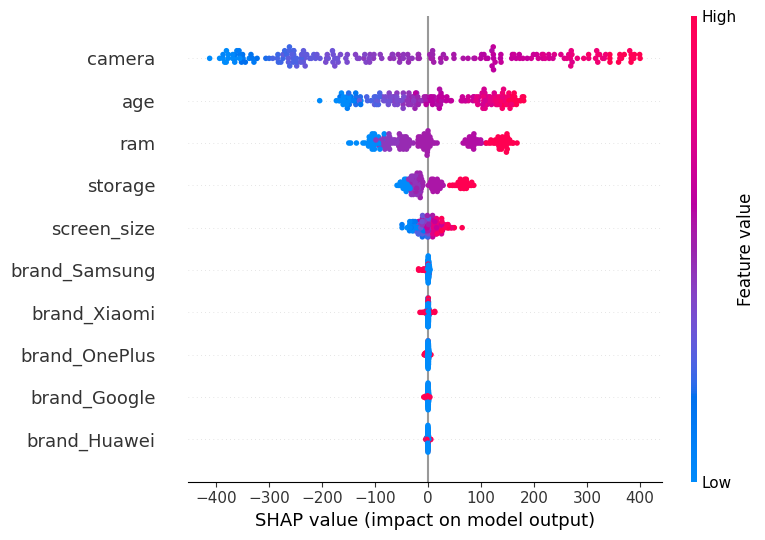

In [18]:
# %% Cell 7: SHAP Explainability

def explain_model(model, X_train, X_test, feature_names):
    """
    Generate a SHAP summary plot for the provided model.
    For tree-based models, TreeExplainer is preferred.
    """
    if hasattr(model, "get_booster"):  # XGBoost
        explainer = shap.TreeExplainer(model)
    elif isinstance(model, CatBoostRegressor):
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.Explainer(model.predict, X_train)

    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)

# For example, explain the XGBoost model
explain_model(models['xgb'], X_train, X_test, feature_names)


In [19]:
# %% Cell 8: Save Artifacts for Deployment

def save_for_deployment(model, scaler, filename_prefix="mobile_price_model"):
    """
    Save the trained model and scaler using joblib.
    """
    joblib.dump(model, f'{filename_prefix}.pkl')
    joblib.dump(scaler, f'{filename_prefix}_scaler.pkl')
    print("Artifacts saved for deployment.")

# Save the best performing model (using XGBoost here for demonstration)
save_for_deployment(models['xgb'], scaler)


Artifacts saved for deployment.


In [20]:
# %% Cell 9: Advanced Visualizations and 3D Charts

import plotly.express as px
import plotly.graph_objects as go

# --- 3D Scatter Plot: Price vs. Age vs. RAM ---
fig_3d = px.scatter_3d(
    df_mobiles,
    x="age",
    y="ram",
    z="price",
    color="brand",
    size="storage",
    hover_data=["model", "screen_size", "camera"],
    title="3D Scatter Plot: Age vs. RAM vs. Price"
)
fig_3d.update_layout(scene=dict(
    xaxis_title="Device Age (years)",
    yaxis_title="RAM (GB)",
    zaxis_title="Price (USD)"
))
fig_3d.show()

# --- 3D Scatter Plot: Price vs. Storage vs. Screen Size ---
fig_3d_2 = px.scatter_3d(
    df_mobiles,
    x="storage",
    y="screen_size",
    z="price",
    color="brand",
    size="ram",
    hover_data=["model", "age", "camera"],
    title="3D Scatter Plot: Storage vs. Screen Size vs. Price"
)
fig_3d_2.update_layout(scene=dict(
    xaxis_title="Storage (GB)",
    yaxis_title="Screen Size (inches)",
    zaxis_title="Price (USD)"
))
fig_3d_2.show()

# --- Correlation Heatmap ---
# Create a correlation matrix using key numerical features
corr_features = df_mobiles[["age", "ram", "storage", "camera", "screen_size", "price"]]
corr_matrix = corr_features.corr()

fig_heatmap = px.imshow(
    corr_matrix,
    text_auto=True,
    aspect="auto",
    title="Correlation Heatmap of Mobile Features"
)
fig_heatmap.update_layout(xaxis_title="Features", yaxis_title="Features")
fig_heatmap.show()

# --- Box Plot: Price Distribution by Brand ---
fig_box = px.box(
    df_mobiles,
    x="brand",
    y="price",
    color="brand",
    title="Price Distribution by Brand",
    points="all"
)
fig_box.update_layout(xaxis_title="Brand", yaxis_title="Price (USD)")
fig_box.show()

# --- Distribution Plot: Price Distribution ---
fig_hist = px.histogram(
    df_mobiles,
    x="price",
    nbins=50,
    title="Price Distribution Across Mobile Phones",
    labels={"price": "Price (USD)"}
)
fig_hist.update_layout(xaxis_title="Price (USD)", yaxis_title="Count")
fig_hist.show()


In [21]:
# %% Cell 1: Import Libraries
import numpy as np
import pandas as pd
import datetime
import os
import joblib

# Machine Learning & Preprocessing Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import QuantileTransformer

# Advanced ML libraries
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from pytorch_tabnet.tab_model import TabNetRegressor

# Deep Learning (Transformer-based model)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer

# Hyperparameter Optimization and Explainability
import optuna
import shap

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# For progress display
from tqdm import tqdm

# Set Plot Style for matplotlib/seaborn
sns.set(style="whitegrid")


In [22]:
# %% Cell 2: Global Settings & Seed Initialization
np.random.seed(42)
torch.manual_seed(42)
CURRENT_YEAR = datetime.datetime.now().year


In [23]:
# %% Cell 3: Data Collection – Load Predefined Dataset
DATA_PATH = "latest_mobile_data.csv"

if os.path.exists(DATA_PATH):
    df_mobiles = pd.read_csv(DATA_PATH)
    print(f"Loaded dataset from {DATA_PATH}.")
else:
    print(f"Dataset '{DATA_PATH}' not found. Generating synthetic dataset for demonstration.")
    df_mobiles = pd.DataFrame({
        "brand": np.random.choice(["Samsung", "Apple", "Xiaomi", "Google", "OnePlus", "Huawei"], 1000),
        "model": np.random.choice(["Model A", "Model B", "Model C", "Model D"], 1000),
        "release_year": np.random.randint(2000, CURRENT_YEAR+1, 1000),
        "ram": np.random.choice([2, 4, 6, 8, 12, 16], 1000),
        "storage": np.random.choice([32, 64, 128, 256, 512], 1000),
        "camera": np.random.uniform(8, 108, 1000),
        "screen_size": np.random.uniform(4.5, 7.0, 1000)
    })

    def simulate_price(row):
        # A heuristic formula for synthetic pricing
        age_factor = (CURRENT_YEAR - row["release_year"])
        base_price = 50
        price = base_price + age_factor * 15 + row["ram"] * 20 + row["storage"] * 0.3 + row["camera"] * 8 + row["screen_size"] * 30
        price += np.random.normal(0, 50)
        return max(price, 50)

    df_mobiles["price"] = df_mobiles.apply(simulate_price, axis=1)

print("Collected mobile data sample:")
print(df_mobiles.head())


Dataset 'latest_mobile_data.csv' not found. Generating synthetic dataset for demonstration.
Collected mobile data sample:
     brand    model  release_year  ram  storage     camera  screen_size  \
0   Google  Model B          2017    2      512  80.192923     4.666735   
1  OnePlus  Model A          2003    4      256  46.480362     4.620231   
2   Xiaomi  Model B          2001    8      512  56.937645     5.239163   
3  OnePlus  Model B          2013   12      512  50.960859     6.831361   
4  OnePlus  Model C          2012    2       32  82.062615     5.808033   

         price  
0  1177.354916  
1   969.020666  
2  1280.644509  
3  1234.593202  
4  1084.969787  


In [24]:
# %% Cell 4: Exploratory Data Analysis (EDA)
print("Dataset Shape:", df_mobiles.shape)
print("\nDataset Info:")
print(df_mobiles.info())
print("\nSummary Statistics:")
print(df_mobiles.describe())
print("\nMissing Values per Column:")
print(df_mobiles.isnull().sum())


Dataset Shape: (1000, 8)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   brand         1000 non-null   object 
 1   model         1000 non-null   object 
 2   release_year  1000 non-null   int64  
 3   ram           1000 non-null   int64  
 4   storage       1000 non-null   int64  
 5   camera        1000 non-null   float64
 6   screen_size   1000 non-null   float64
 7   price         1000 non-null   float64
dtypes: float64(3), int64(3), object(2)
memory usage: 62.6+ KB
None

Summary Statistics:
       release_year         ram      storage       camera  screen_size  \
count   1000.000000  1000.00000  1000.000000  1000.000000  1000.000000   
mean    2012.180000     8.06200   197.632000    58.360591     5.724978   
std        7.469766     4.75213   175.297604    28.589871     0.715633   
min     2000.000000     2.00000    32.00

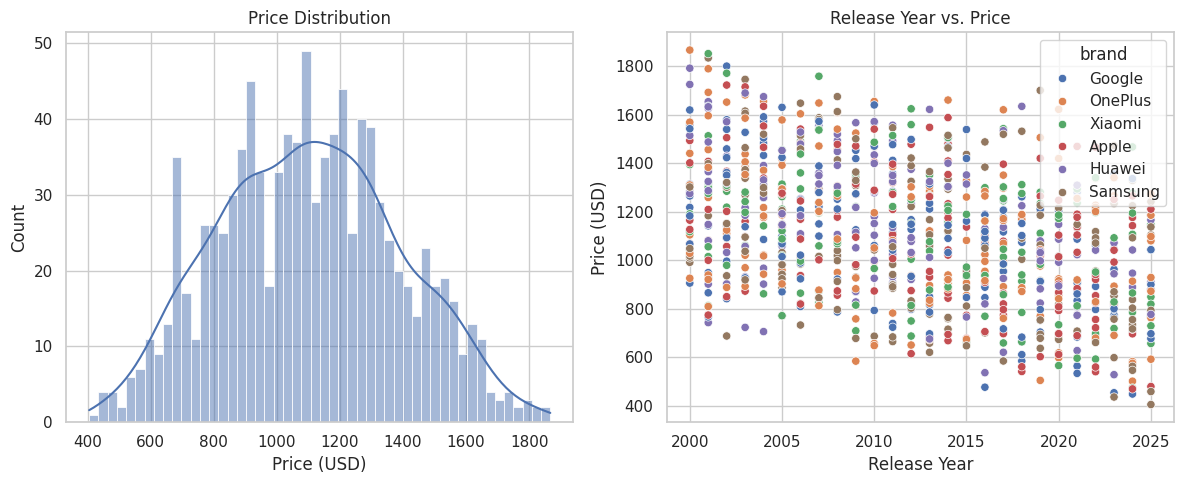

In [25]:
# %% Cell 5: Basic Data Visualization
plt.figure(figsize=(12, 5))

# Histogram of Prices
plt.subplot(1, 2, 1)
sns.histplot(df_mobiles["price"], bins=50, kde=True)
plt.title("Price Distribution")
plt.xlabel("Price (USD)")

# Scatter Plot: Release Year vs. Price
plt.subplot(1, 2, 2)
sns.scatterplot(x="release_year", y="price", data=df_mobiles, hue="brand")
plt.title("Release Year vs. Price")
plt.xlabel("Release Year")
plt.ylabel("Price (USD)")
plt.tight_layout()
plt.show()


In [26]:
# %% Cell 6: Data Preprocessing and Feature Engineering
def preprocess_mobile_data(df):
    # Create a new feature: device age
    df['age'] = CURRENT_YEAR - df['release_year']

    # One-hot encode categorical variable: brand
    df_encoded = pd.get_dummies(df, columns=['brand'], drop_first=True)

    # Define features (drop model and release_year) and target
    X = df_encoded.drop(['price', 'release_year', 'model'], axis=1)
    y = df_encoded['price']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize features using QuantileTransformer
    scaler = QuantileTransformer(output_distribution='normal', random_state=42)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train.values, y_test.values, scaler, X.columns

X_train, X_test, y_train, y_test, scaler, feature_names = preprocess_mobile_data(df_mobiles)
print("Preprocessing complete. Feature columns:")
print(feature_names)


Preprocessing complete. Feature columns:
Index(['ram', 'storage', 'camera', 'screen_size', 'age', 'brand_Google',
       'brand_Huawei', 'brand_OnePlus', 'brand_Samsung', 'brand_Xiaomi'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning:

n_quantiles (1000) is greater than the total number of samples (800). n_quantiles is set to n_samples.



In [27]:
# %% Cell 7: Advanced Visualization – Correlation Heatmap using Plotly
# Compute correlation matrix for key features
corr_features = df_mobiles[["age", "ram", "storage", "camera", "screen_size", "price"]]
corr_matrix = corr_features.corr()

fig_heatmap = px.imshow(
    corr_matrix,
    text_auto=True,
    aspect="auto",
    title="Correlation Heatmap of Mobile Features"
)
fig_heatmap.update_layout(xaxis_title="Features", yaxis_title="Features")
fig_heatmap.show()


In [28]:
# %% Cell 8: Define Standard ML Models
# XGBoost, LightGBM, and CatBoost models will be instantiated later in training cells.
# For now, we just import and set default parameters if needed.
xgb_default = XGBRegressor(random_state=42, verbosity=0)
lgbm_default = LGBMRegressor(random_state=42)
cat_default = CatBoostRegressor(random_seed=42, verbose=0)


In [29]:
# %% Cell 9: Define TabNet Model Wrapper
class TabNetModel:
    def __init__(self, seed=42):
        self.model = TabNetRegressor(
            n_d=32,
            n_a=32,
            n_steps=5,
            gamma=1.5,
            optimizer_params={'lr': 2e-2},
            seed=seed,
            verbose=0
        )

    def fit(self, X_train, y_train, X_val, y_val):
        self.model.fit(
            X_train, y_train.reshape(-1, 1),
            eval_set=[(X_val, y_val.reshape(-1, 1))],
            max_epochs=100,
            patience=20,
            batch_size=1024,
            virtual_batch_size=64
        )

    def predict(self, X):
        return self.model.predict(X)


In [30]:
# %% Cell 10: Define Transformer-based Tabular Model
class TransformerTabularModel(nn.Module):
    """
    A simple transformer-based architecture for tabular data.
    """
    def __init__(self, num_features, hidden_dim=128, nhead=4, num_layers=2):
        super().__init__()
        # Create an embedding for each feature (treating feature indices as tokens)
        self.embedding = nn.Embedding(num_features, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch_size, num_features) with integer feature indices
        x = self.embedding(x)  # (batch_size, num_features, hidden_dim)
        # Permute for transformer: (num_features, batch_size, hidden_dim)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        # Aggregate using mean pooling
        x = x.mean(dim=0)
        x = self.fc(x)
        return x


In [31]:
# %% Cell 11: Hyperparameter Tuning with Optuna
def objective(trial):
    model_type = trial.suggest_categorical('model', ['xgb', 'lgbm', 'catboost'])

    if model_type == 'xgb':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'verbosity': 0,
            'random_state': 42
        }
        model = XGBRegressor(**params)
    elif model_type == 'lgbm':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'num_leaves': trial.suggest_int('num_leaves', 31, 127),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'random_state': 42
        }
        model = LGBMRegressor(**params)
    else:  # catboost
        params = {
            'iterations': trial.suggest_int('iterations', 500, 2000),
            'depth': trial.suggest_int('depth', 4, 10),
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
            'random_seed': 42,
            'verbose': 0
        }
        model = CatBoostRegressor(**params)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

def tune_hyperparameters(n_trials=20):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    print("Best hyperparameters:")
    print(study.best_params)
    return study.best_params

# Uncomment to run hyperparameter tuning:
# best_params = tune_hyperparameters(n_trials=20)


In [32]:
# %% Cell 12: Train and Evaluate XGBoost Model
print("Training XGBoost model...")
xgb_model = XGBRegressor(random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
print(f"XGBoost MAE: {xgb_mae:.2f}")


Training XGBoost model...
XGBoost MAE: 56.62


In [33]:
# %% Cell 13: Train and Evaluate LightGBM and CatBoost Models

# LightGBM
print("Training LightGBM model...")
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_test)
lgbm_mae = mean_absolute_error(y_test, lgbm_preds)
print(f"LightGBM MAE: {lgbm_mae:.2f}")

# CatBoost
print("Training CatBoost model...")
cat_model = CatBoostRegressor(random_seed=42, verbose=0)
cat_model.fit(X_train, y_train)
cat_preds = cat_model.predict(X_test)
cat_mae = mean_absolute_error(y_test, cat_preds)
print(f"CatBoost MAE: {cat_mae:.2f}")


Training LightGBM model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 565
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Info] Start training from score 1104.221769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



CatBoost MAE: 44.89


In [34]:
# %% Cell 14: Train and Evaluate TabNet Model
print("Training TabNet model...")
tabnet_model = TabNetModel()
tabnet_model.fit(X_train, y_train, X_test, y_test)
tabnet_preds = tabnet_model.predict(X_test)
tabnet_mae = mean_absolute_error(y_test, tabnet_preds)
print(f"TabNet MAE: {tabnet_mae:.2f}")


Training TabNet model...

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_mse = 1321757.82915
TabNet MAE: 1111.51


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning:

Best weights from best epoch are automatically used!

/usr/local/lib/python3.11/dist-packages/torch/utils/data/_utils/collate.py:285: UserWarning:

The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)



In [35]:
# %% Cell 15: Compare Model Performance
performance = pd.DataFrame({
    "Model": ["XGBoost", "LightGBM", "CatBoost", "TabNet"],
    "MAE": [xgb_mae, lgbm_mae, cat_mae, tabnet_mae]
})
print("Model Performance Comparison:")
display(performance)


Model Performance Comparison:


,Model,MAE
0,XGBoost,56.622727
1,LightGBM,49.545244
2,CatBoost,44.891741
3,TabNet,1111.511197


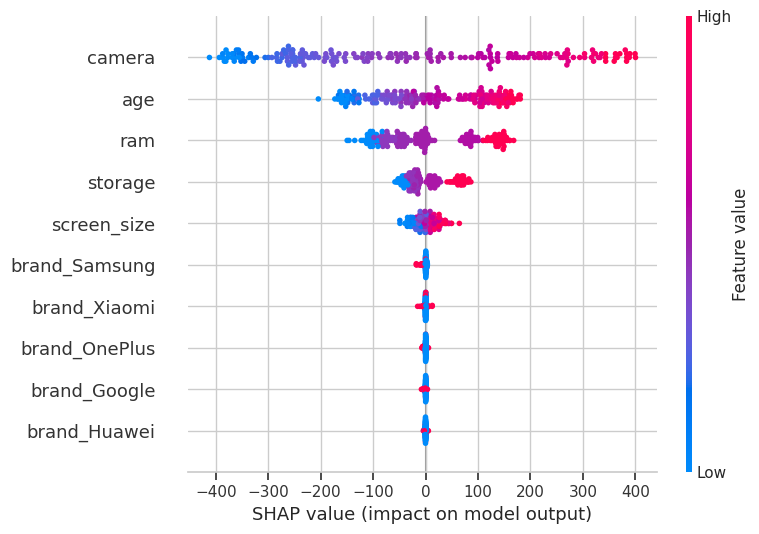

In [36]:
# %% Cell 16: SHAP Explainability for the Best Model
# Let's assume XGBoost was the best performing model.
def explain_model(model, X_train, X_test, feature_names):
    if hasattr(model, "get_booster"):  # XGBoost
        explainer = shap.TreeExplainer(model)
    elif isinstance(model, CatBoostRegressor):
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.Explainer(model.predict, X_train)

    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=feature_names)

explain_model(xgb_model, X_train, X_test, feature_names)


In [37]:
# %% Cell 17: Advanced Visualizations – 3D Scatter & Interactive Charts with Plotly

# 3D Scatter Plot: Age vs. RAM vs. Price
fig_3d = px.scatter_3d(
    df_mobiles,
    x="age",
    y="ram",
    z="price",
    color="brand",
    size="storage",
    hover_data=["model", "screen_size", "camera"],
    title="3D Scatter Plot: Age vs. RAM vs. Price"
)
fig_3d.update_layout(scene=dict(
    xaxis_title="Device Age (years)",
    yaxis_title="RAM (GB)",
    zaxis_title="Price (USD)"
))
fig_3d.show()

# 3D Scatter Plot: Storage vs. Screen Size vs. Price
fig_3d_2 = px.scatter_3d(
    df_mobiles,
    x="storage",
    y="screen_size",
    z="price",
    color="brand",
    size="ram",
    hover_data=["model", "age", "camera"],
    title="3D Scatter Plot: Storage vs. Screen Size vs. Price"
)
fig_3d_2.update_layout(scene=dict(
    xaxis_title="Storage (GB)",
    yaxis_title="Screen Size (inches)",
    zaxis_title="Price (USD)"
))
fig_3d_2.show()

# Additional Interactive Histogram for Price
fig_hist = px.histogram(
    df_mobiles,
    x="price",
    nbins=50,
    title="Interactive Price Distribution",
    labels={"price": "Price (USD)"}
)
fig_hist.update_layout(xaxis_title="Price (USD)", yaxis_title="Count")
fig_hist.show()


<ipython-input-38-0a8e266c3a18>:157: FutureWarning:



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.




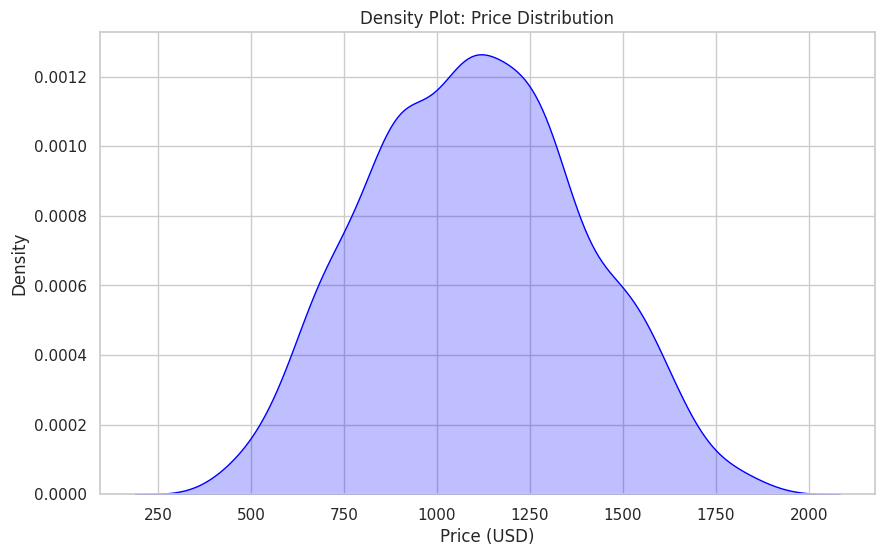

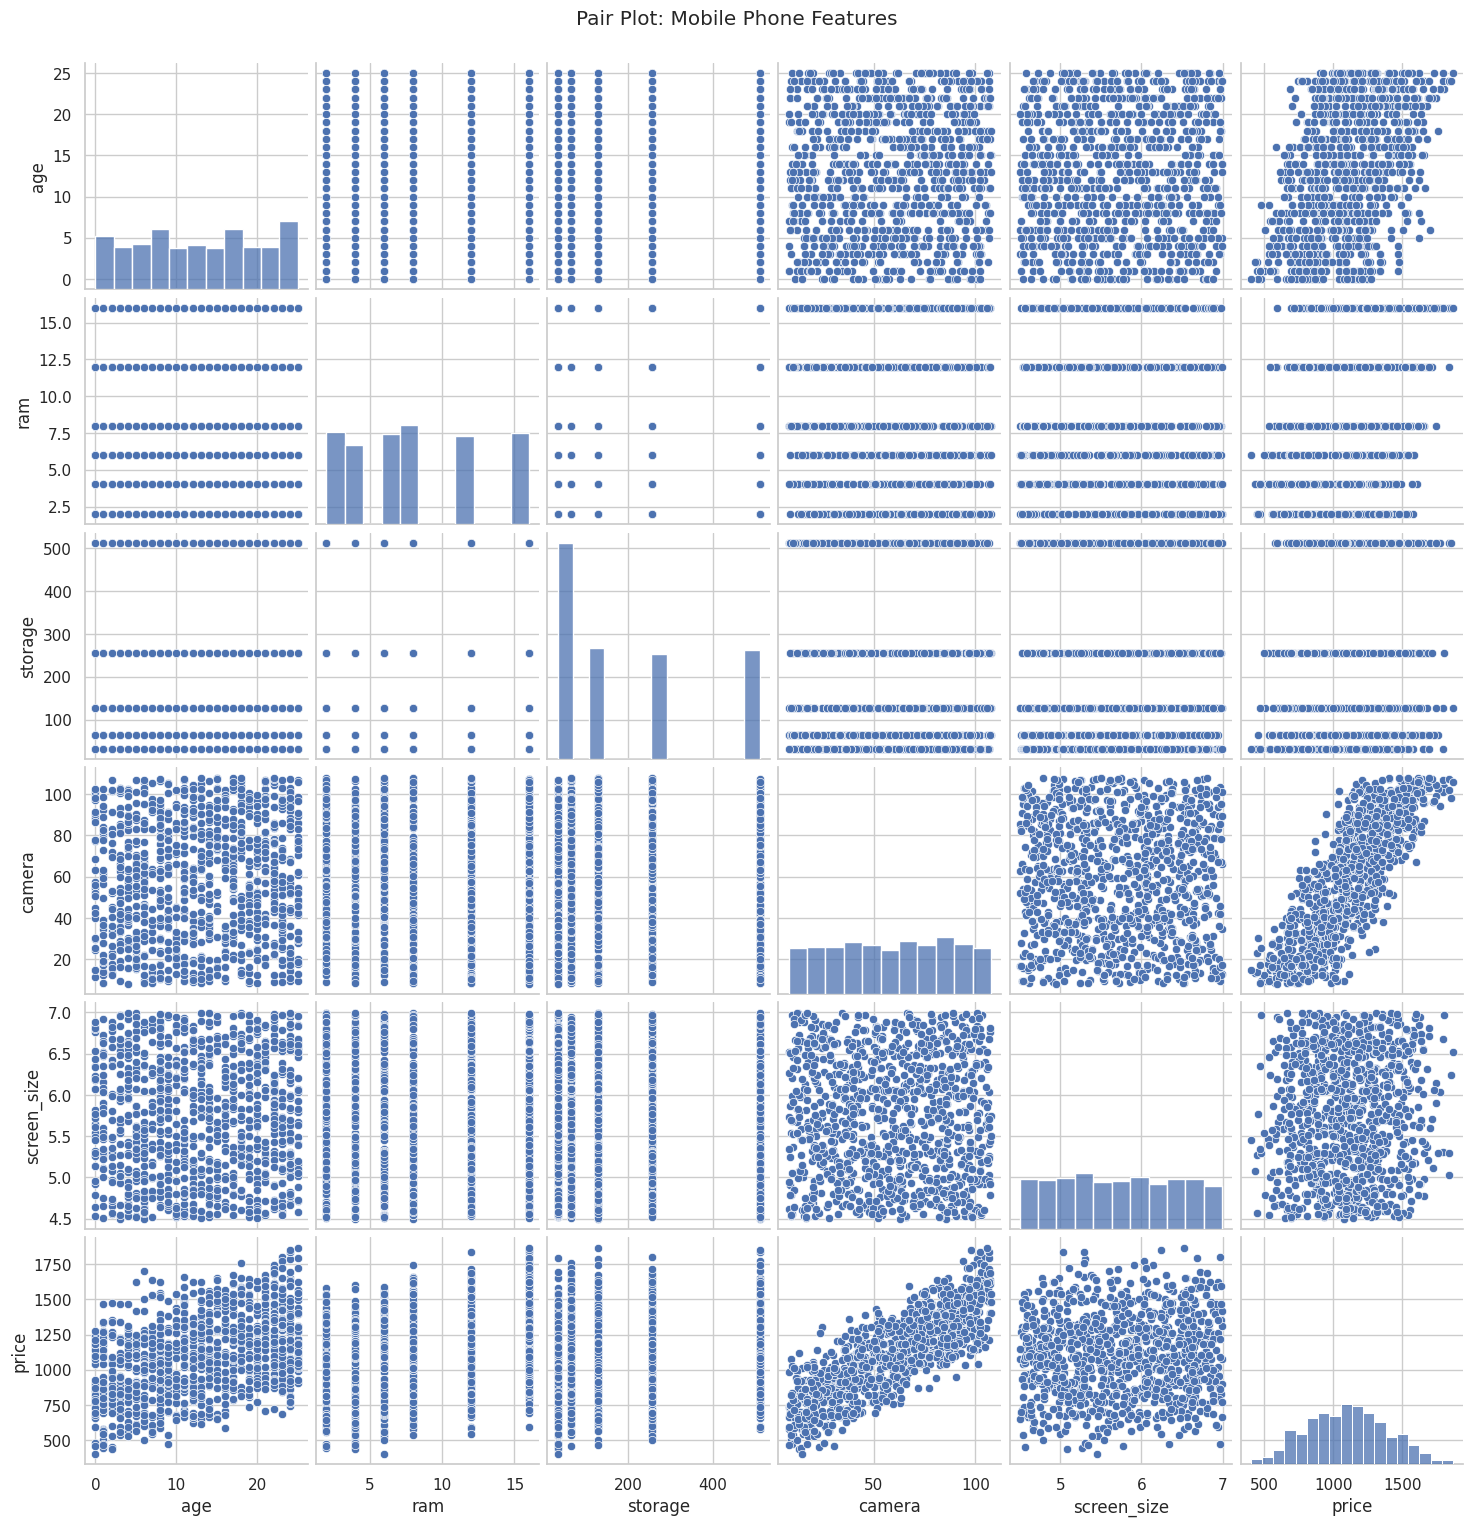

In [38]:
# Everything in One Cell: 22 Distinct Graphs for the Mobile Dataset

import numpy as np
import pandas as pd
import datetime
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

# Generate synthetic dataset if not already available
if 'df_mobiles' not in globals():
    current_year = datetime.datetime.now().year
    df_mobiles = pd.DataFrame({
        "brand": np.random.choice(["Samsung", "Apple", "Xiaomi", "Google", "OnePlus", "Huawei"], 1000),
        "model": np.random.choice(["Model A", "Model B", "Model C", "Model D"], 1000),
        "release_year": np.random.randint(2000, current_year+1, 1000),
        "ram": np.random.choice([2, 4, 6, 8, 12, 16], 1000),
        "storage": np.random.choice([32, 64, 128, 256, 512], 1000),
        "camera": np.random.uniform(8, 108, 1000),
        "screen_size": np.random.uniform(4.5, 7.0, 1000)
    })
    def simulate_price(row):
        age_factor = (current_year - row["release_year"])
        base_price = 50
        price = base_price + age_factor * 15 + row["ram"] * 20 + row["storage"] * 0.3 + row["camera"] * 8 + row["screen_size"] * 30
        price += np.random.normal(0, 50)
        return max(price, 50)
    df_mobiles["price"] = df_mobiles.apply(simulate_price, axis=1)
    df_mobiles["age"] = current_year - df_mobiles["release_year"]

# GRAPH 1: 3D Scatter Plot – Age vs. RAM vs. Price
fig1 = px.scatter_3d(
    df_mobiles,
    x="age",
    y="ram",
    z="price",
    color="brand",
    size="storage",
    hover_data=["model", "screen_size", "camera"],
    title="3D Scatter: Age vs. RAM vs. Price"
)
fig1.update_layout(scene=dict(xaxis_title="Age (years)", yaxis_title="RAM (GB)", zaxis_title="Price (USD)"))
fig1.show()

# GRAPH 2: 3D Scatter Plot – Storage vs. Screen Size vs. Price
fig2 = px.scatter_3d(
    df_mobiles,
    x="storage",
    y="screen_size",
    z="price",
    color="brand",
    size="ram",
    hover_data=["model", "age", "camera"],
    title="3D Scatter: Storage vs. Screen Size vs. Price"
)
fig2.update_layout(scene=dict(xaxis_title="Storage (GB)", yaxis_title="Screen Size (inches)", zaxis_title="Price (USD)"))
fig2.show()

# GRAPH 3: Correlation Heatmap of Numerical Features
num_features = df_mobiles[["age", "ram", "storage", "camera", "screen_size", "price"]]
corr_matrix = num_features.corr()
fig3 = px.imshow(corr_matrix, text_auto=True, aspect="auto", title="Correlation Heatmap of Mobile Features")
fig3.update_layout(xaxis_title="Features", yaxis_title="Features")
fig3.show()

# GRAPH 4: Box Plot – Price Distribution by Brand
fig4 = px.box(
    df_mobiles,
    x="brand",
    y="price",
    color="brand",
    title="Box Plot: Price Distribution by Brand",
    points="all"
)
fig4.update_layout(xaxis_title="Brand", yaxis_title="Price (USD)")
fig4.show()

# GRAPH 5: Histogram – Overall Price Distribution
fig5 = px.histogram(
    df_mobiles,
    x="price",
    nbins=50,
    title="Histogram: Price Distribution",
    labels={"price": "Price (USD)"}
)
fig5.update_layout(xaxis_title="Price (USD)", yaxis_title="Count")
fig5.show()

# GRAPH 6: Bar Chart – Average Price per Brand
avg_price = df_mobiles.groupby("brand")["price"].mean().reset_index()
fig6 = px.bar(
    avg_price,
    x="brand",
    y="price",
    color="brand",
    title="Bar Chart: Average Price per Brand",
    labels={"price": "Average Price (USD)"}
)
fig6.update_layout(xaxis_title="Brand", yaxis_title="Average Price (USD)")
fig6.show()

# GRAPH 7: Scatter Plot – Price vs. Storage (Colored by Brand)
fig7 = px.scatter(
    df_mobiles,
    x="storage",
    y="price",
    color="brand",
    size="ram",
    hover_data=["model", "age"],
    title="Scatter Plot: Price vs. Storage"
)
fig7.update_layout(xaxis_title="Storage (GB)", yaxis_title="Price (USD)")
fig7.show()

# GRAPH 8: Scatter Plot – Price vs. Camera (Colored by Brand)
fig8 = px.scatter(
    df_mobiles,
    x="camera",
    y="price",
    color="brand",
    size="screen_size",
    hover_data=["model", "age"],
    title="Scatter Plot: Price vs. Camera"
)
fig8.update_layout(xaxis_title="Camera (MP)", yaxis_title="Price (USD)")
fig8.show()

# GRAPH 9: Line Chart – Average Price over Release Year
price_year = df_mobiles.groupby("release_year")["price"].mean().reset_index()
fig9 = px.line(
    price_year,
    x="release_year",
    y="price",
    markers=True,
    title="Line Chart: Average Price over Release Year"
)
fig9.update_layout(xaxis_title="Release Year", yaxis_title="Average Price (USD)")
fig9.show()

# GRAPH 10: Violin Plot – Price Distribution by Brand
fig10 = px.violin(
    df_mobiles,
    x="brand",
    y="price",
    color="brand",
    box=True,
    points="all",
    title="Violin Plot: Price Distribution by Brand"
)
fig10.update_layout(xaxis_title="Brand", yaxis_title="Price (USD)")
fig10.show()

# GRAPH 11: Density Plot (KDE) of Price Distribution using Seaborn
plt.figure(figsize=(10, 6))
sns.kdeplot(df_mobiles["price"], shade=True, color="blue")
plt.title("Density Plot: Price Distribution")
plt.xlabel("Price (USD)")
plt.ylabel("Density")
plt.show()

# GRAPH 12: Pair Plot of Numerical Features using Seaborn
sns.pairplot(df_mobiles[["age", "ram", "storage", "camera", "screen_size", "price"]])
plt.suptitle("Pair Plot: Mobile Phone Features", y=1.02)
plt.show()

# GRAPH 13: Bubble Chart – Price vs. Age with Bubble Size as RAM
fig11 = px.scatter(
    df_mobiles,
    x="age",
    y="price",
    size="ram",
    color="brand",
    hover_data=["model", "storage"],
    title="Bubble Chart: Price vs. Age (Bubble Size = RAM)"
)
fig11.update_layout(xaxis_title="Age (years)", yaxis_title="Price (USD)")
fig11.show()

# GRAPH 14: Sunburst Chart – Hierarchical Breakdown (Brand > Model > Price)
fig12 = px.sunburst(
    df_mobiles,
    path=["brand", "model"],
    values="price",
    color="price",
    title="Sunburst Chart: Brand and Model Breakdown by Price"
)
fig12.show()

# GRAPH 15: Treemap – Average Price by Brand
avg_price_brand = df_mobiles.groupby("brand")["price"].mean().reset_index()
fig13 = px.treemap(
    avg_price_brand,
    path=["brand"],
    values="price",
    color="price",
    color_continuous_scale="RdBu",
    title="Treemap: Average Price by Brand"
)
fig13.show()

# GRAPH 16: Radar Chart – Features for a Specific Brand (e.g., Apple)
brand_choice = "Apple"
brand_data = df_mobiles[df_mobiles["brand"] == brand_choice]
features = ["ram", "storage", "camera", "screen_size", "age"]
avg_features = brand_data[features].mean()
categories = features + [features[0]]
values = avg_features.tolist() + [avg_features[features[0]]]
fig14 = go.Figure(
    data=go.Scatterpolar(
        r=values,
        theta=categories,
        fill="toself",
        name=f"{brand_choice} Average Features"
    )
)
fig14.update_layout(polar=dict(radialaxis=dict(visible=True)), title=f"Radar Chart: Average Features for {brand_choice}")
fig14.show()

# GRAPH 17: Scatter Plot with Trendline – Price vs. Storage
fig15 = px.scatter(
    df_mobiles,
    x="storage",
    y="price",
    trendline="ols",
    color="brand",
    title="Scatter Plot with Trendline: Price vs. Storage"
)
fig15.update_layout(xaxis_title="Storage (GB)", yaxis_title="Price (USD)")
fig15.show()

# GRAPH 18: Parallel Coordinates Plot of Numerical Features
fig16 = px.parallel_coordinates(
    df_mobiles,
    dimensions=["age", "ram", "storage", "camera", "screen_size", "price"],
    color="price",
    color_continuous_scale=px.colors.diverging.Tealrose,
    title="Parallel Coordinates Plot of Mobile Features"
)
fig16.show()

# GRAPH 19: Scatter Matrix Plot using Plotly
fig17 = px.scatter_matrix(
    df_mobiles,
    dimensions=["age", "ram", "storage", "camera", "screen_size", "price"],
    color="brand",
    title="Scatter Matrix of Mobile Phone Features"
)
fig17.update_layout(width=800, height=800)
fig17.show()

# GRAPH 20: Contour Plot – Price vs. Age (Density Contour)
fig18 = px.density_contour(
    df_mobiles,
    x="age",
    y="price",
    title="Contour Plot: Price vs. Age",
    labels={"age": "Age (years)", "price": "Price (USD)"}
)
fig18.update_traces(contours_coloring="fill", contours_showlabels=True)
fig18.show()

# GRAPH 21: Combined Chart – Scatter & Histogram (Price vs. Age)
fig19 = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=("Scatter Plot: Price vs. Age", "Histogram of Price")
)
fig19.add_trace(
    go.Scatter(
        x=df_mobiles["age"],
        y=df_mobiles["price"],
        mode="markers",
        marker=dict(color="rgba(0, 128, 200, 0.7)"),
        name="Price vs. Age"
    ),
    row=1, col=1
)
fig19.add_trace(
    go.Histogram(
        x=df_mobiles["price"],
        marker=dict(color="rgba(200, 0, 100, 0.7)"),
        name="Price Distribution"
    ),
    row=2, col=1
)
fig19.update_layout(
    title_text="Combined Scatter & Histogram Chart",
    xaxis2_title="Price (USD)",
    yaxis1_title="Price (USD)",
    yaxis2_title="Count"
)
fig19.show()

# GRAPH 22: 3D Surface Plot – Price Landscape (Age vs. RAM)
age_bins = np.linspace(df_mobiles["age"].min(), df_mobiles["age"].max(), 20)
ram_bins = np.linspace(df_mobiles["ram"].min(), df_mobiles["ram"].max(), 20)
age_centers = (age_bins[:-1] + age_bins[1:]) / 2
ram_centers = (ram_bins[:-1] + ram_bins[1:]) / 2
surface = np.zeros((len(ram_centers), len(age_centers)))
for i, r in enumerate(ram_centers):
    for j, a in enumerate(age_centers):
        mask = (df_mobiles["ram"] >= ram_bins[i]) & (df_mobiles["ram"] < ram_bins[i+1]) & (df_mobiles["age"] >= age_bins[j]) & (df_mobiles["age"] < age_bins[j+1])
        if mask.sum() > 0:
            surface[i, j] = df_mobiles.loc[mask, "price"].mean()
        else:
            surface[i, j] = np.nan
fig20 = go.Figure(data=[go.Surface(z=surface, x=age_centers, y=ram_centers)])
fig20.update_layout(
    title="3D Surface Plot: Price Landscape (Age vs. RAM)",
    scene=dict(xaxis_title="Age (years)", yaxis_title="RAM (GB)", zaxis_title="Average Price (USD)")
)
fig20.show()
